## Figure 4

![title](../assets/Fig4.png)

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import logging
from tqdm import tqdm
from pathlib import Path

sys.path.insert(0, "./prepare_data/")

import yaml
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import gridspec
import matplotlib_venn
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import Figure4_neurons as neurons
import Figure4_graph_tools as graph_tools
import connectome_utils
from common import *

# import plot_utils

DATA_PATH = Path(
    "../data"
)
EXPORT_PATH = Path(
    "../results/Figure4"
)
EXPORT_PATH.mkdir(exist_ok=True, parents=True)


FIGSIZE = {'width': 1.2, 'length': 0.9}

# disable matplotlib logger
logging.getLogger("matplotlib.font_manager").disabled = True

plt.style.use('./config.mplstyle')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Panel B: connectivity between previously identified antennal grooming neurons

### Antennal groming network construction:
- We used the previously identified antennal grooming neurons to construct a network of these neurons. See `prepare_data/Figure4_generate_grooming_network.py` for details on how to generate this network.
- After constructing the extended grooming network, we semi-automatically identified the mirror twins of each found neuron in this extensive network, when applicable. Please see `EDFigure10.ipynb` and our paper for more details.

In [10]:
grooming_network = load_data(DATA_PATH / "Fig4_grooming_network_sensory_merged.pkl")

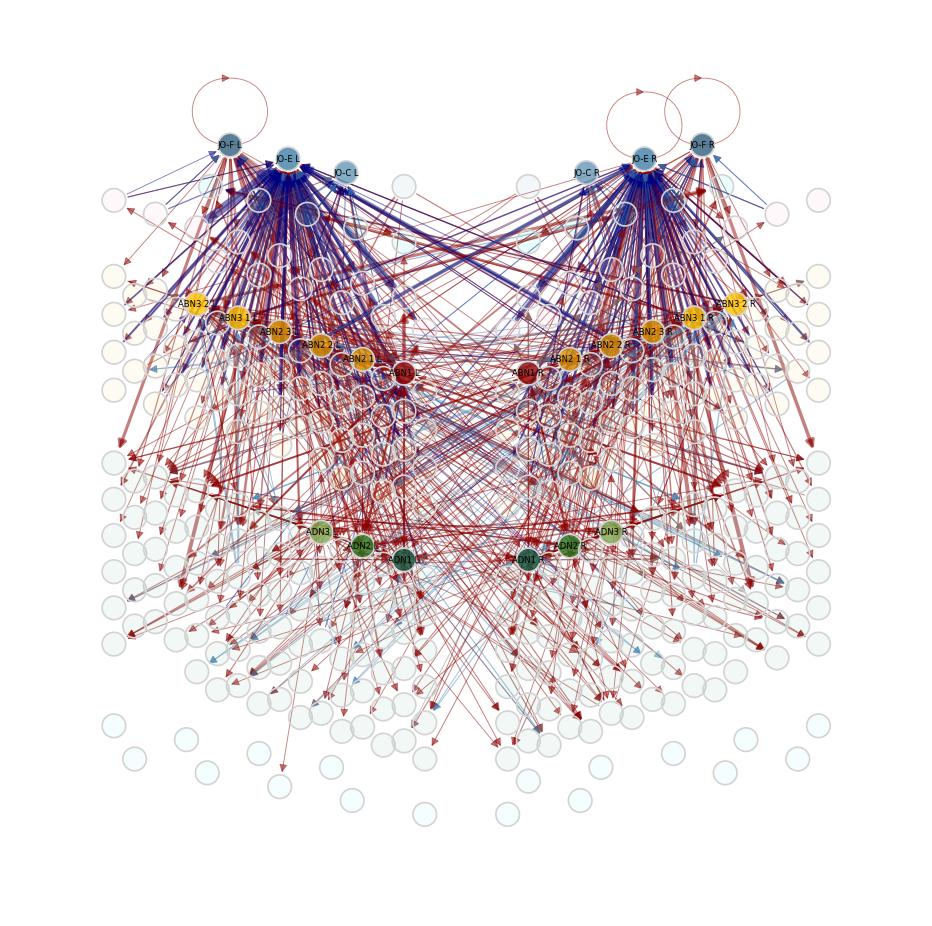

In [11]:
hampel_2015_neurons = {
    **{
        neuron: n_dict
        for neuron, n_dict in neurons.neuron_dict['sensory_neurons'].items()
        if not neuron[:2] == "BM"
    },
    **neurons.neuron_dict['ABN'],
    **neurons.neuron_dict['ADN'],
}

network_specs_ant, G_clean_ant = connectome_utils.plot_connectivity(
    grooming_network, neurons.ALL_NEURONS_REV_JO,
    highlight_neuron=[n_dict['id'] for _, n_dict in hampel_2015_neurons.items()],
    export_path=EXPORT_PATH / "Fig4_panelB.png",
    node_size=200,
    font_size=5,
    max_w=5,
    synapse_th=0,
)


## Panel C: connectivity between newly identified antennal grooming neurons

Note that some nodes are not shown if no connections were found between them and other neurons in the network.

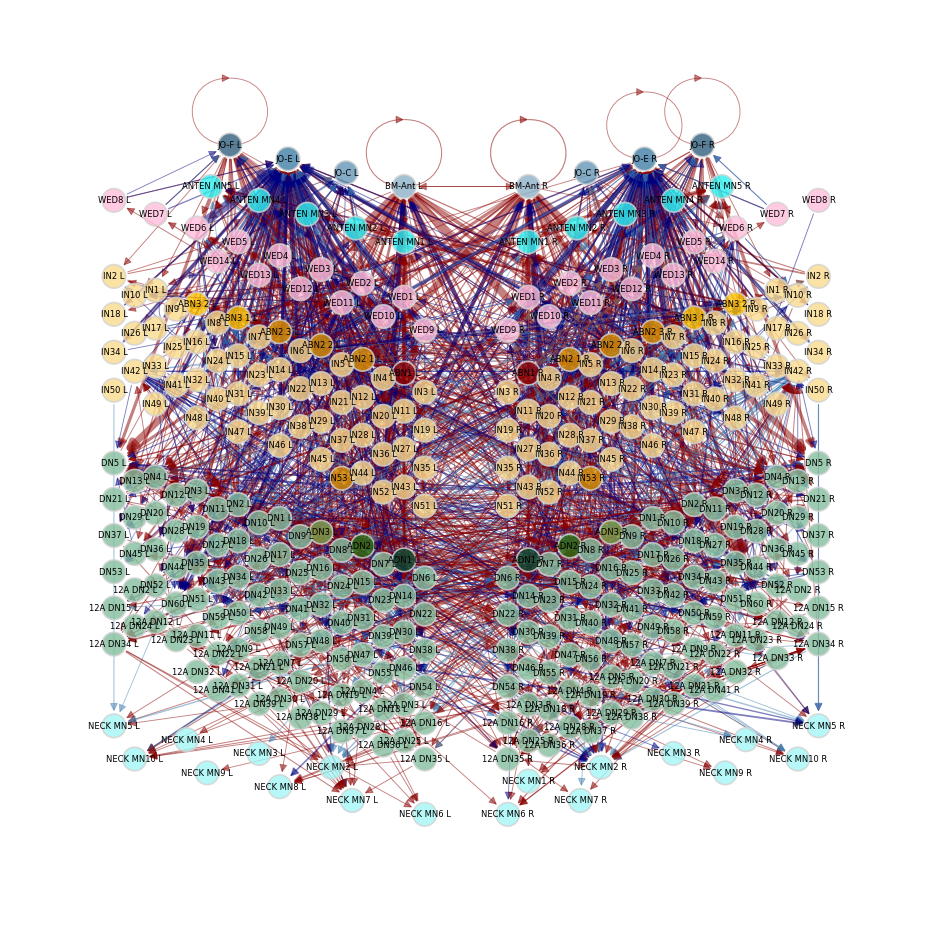

In [12]:
# All neurons and connections are shown
network_specs_JO, G_clean_JO = connectome_utils.plot_connectivity(
    grooming_network, neurons.ALL_NEURONS_REV_JO,
    export_path=EXPORT_PATH / "Fig4_panelC.png",
    node_size=200,
    font_size=5,
    max_w=5,
    synapse_th=0,
)

## Panel D: neuron renderings in FAFB. 

This panel can be obtained via loading the following json files in https://ngl.flywire.ai/:
- ../data/Fig4_panelD_sensory_neurons.json
- ../data/Fig4_panelD_interneurons.json
- ../data/Fig4_panelD_descending_neurons.json
- ../data/Fig4_panelD_motor_neurons.json

## Panel E: adjacency matrix

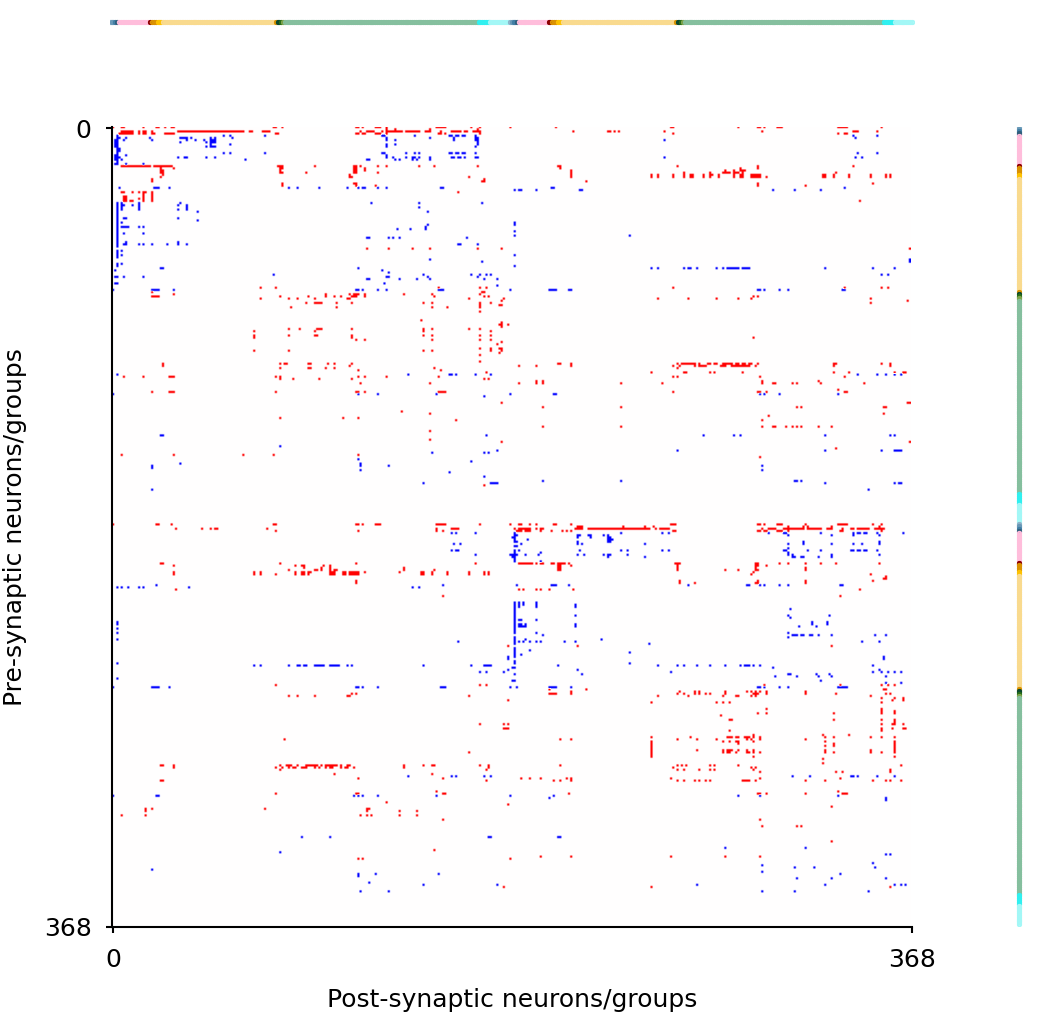

In [13]:
# lets create a list of nodes right and left

neurons_ordered_left = {
    seg_id: neuron_dict
    for seg_id, neuron_dict in neurons.ALL_NEURONS_REV_JO.items()
    if seg_id in network_specs_JO["nodes"]
    if neuron_dict["name"][-2:] == "_L"
}
neurons_ordered_right = {
    seg_id: neuron_dict
    for seg_id, neuron_dict in neurons.ALL_NEURONS_REV_JO.items()
    if seg_id in network_specs_JO["nodes"]
    if neuron_dict["name"][-2:] == "_R"
}

neurons_ordered = {**neurons_ordered_left, **neurons_ordered_right}

# get adjacency matrix
adj_matrix_binary = connectome_utils.make_adjacency_matrix(
    G_clean_JO, neurons_ordered, return_type="binary"
)


with plt.style.context("./config.mplstyle"):
    fig = plt.figure(figsize=(4., 4.), dpi=300)
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.05], height_ratios=[0.05, 1])

    # Main plot for the adjacency matrix
    ax_main = plt.subplot(gs[1, 0])
    ax_top = plt.subplot(gs[0, 0], sharex=ax_main)
    ax_right = plt.subplot(gs[1, 1], sharey=ax_main)

    ax_main.imshow(adj_matrix_binary, cmap="bwr", vmin=-1, vmax=1)

    right_bar = [row_dict["color"] for row, row_dict in neurons_ordered.items()]

    # Plot the color bars
    ax_right.scatter(
        [0] * len(neurons_ordered),
        range(len(neurons_ordered)),
        c=right_bar,
        s=0.1,
        marker="s",
    )
    ax_top.scatter(
        range(len(neurons_ordered)),
        [0] * len(neurons_ordered),
        c=right_bar,
        s=0.1,
        marker="s",
    )

    ax_right.axis("off")  # Turn off the axis
    ax_top.axis("off")  # Turn off the axis

    # spines off for main_axis
    ax_main.spines["right"].set_visible(False)
    ax_main.spines["top"].set_visible(False)
    ax_main.spines["left"].set_visible(True)
    ax_main.spines["bottom"].set_visible(True)

    ax_main.set_xticks([0, adj_matrix_binary.shape[0]])
    ax_main.set_yticks([0, adj_matrix_binary.shape[0]])

    ax_main.set_xlabel("Post-synaptic neurons/groups")
    ax_main.set_ylabel("Pre-synaptic neurons/groups")

    fig.savefig(EXPORT_PATH / "Fig4_panelE.pdf")
    plt.show()

## Panel F: percentage of neurotransmitter types in the antennal grooming network

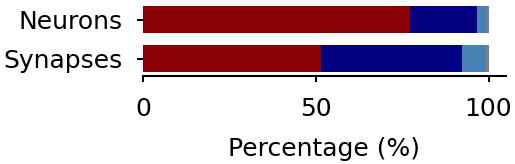

In [14]:
neurotransmitter_types = {
    "GABA": {"color": "navy", "linestyle": ":"},
    "ACH": {"color": "darkred", "linestyle": "--"},
    "GLUT": {"color": "steelblue", "linestyle": ":"},
    "OCT": {"color": "grey", "linestyle": "-"},
    "SER": {"color": "grey", "linestyle": "-"},
    "DA": {"color": "grey", "linestyle": "-"},
    "OTHER": {"color": "grey", "linestyle": "-"},
}

grooming_network_sensory_not_merged = load_data(DATA_PATH / "Fig4_grooming_network_sensory_not_merged.pkl")
scaled_synapse, scaled_neuron = connectome_utils.get_nt_information(grooming_network_sensory_not_merged)

# horizontal stacked bar plot
with plt.style.context("./config.mplstyle"):
    fig, ax = plt.subplots(figsize=(FIGSIZE["width"] * 1.3, FIGSIZE["length"] * 0.35))
    left = 0
    height = 0.7
    for i, (nt_type, count) in enumerate(scaled_synapse.items()):
        p = ax.barh(
            0,
            count,
            color=neurotransmitter_types[nt_type]["color"],
            label=nt_type,
            left=left,
            height=height,
        )
        left += count
    left = 0
    for i, (nt_type, count) in enumerate(scaled_neuron.items()):
        p = ax.barh(
            1,
            count,
            color=neurotransmitter_types[nt_type]["color"],
            label=nt_type,
            left=left,
            height=height,
        )
        left += count
    ax.set_yticks(ticks=[0, 1], labels=["Synapses", "Neurons"])
    ax.set_xticks(ticks=[0, 50, 100], labels=[0, 50, 100])
    # yaxis off
    ax.spines["left"].set_visible(False)
    ax.set_xlabel("Percentage (%)")
    fig.savefig(EXPORT_PATH / "Fig4_panelF.png", bbox_inches="tight")
    plt.show()

## Panel H: grouping neurons based on their location in the sensorimotor pathway from JO-F to motor neurons.

In [15]:
# Load the grooming network
grooming_network = load_data(DATA_PATH / "Fig4_grooming_network_sensory_merged.pkl")
# Load the MN and SN identities
sensory_motor = load_data(DATA_PATH / "Fig4_MN_SN.pkl")

In [16]:
# Neck premotor neurons
neck_ups_percentage = graph_tools.get_premotor_neurons(
    grooming_network, sensory_motor['neck_mn'], threshold=0.05
)
# Ant. premotor neurons
ant_ups_percentage = graph_tools.get_premotor_neurons(
    grooming_network, sensory_motor['anten_mn'], threshold=0.05
)

# Just print
print("Neck premotor neurons")
print(neck_ups_percentage)
print("Ant. premotor neurons")
print(ant_ups_percentage)

Neck premotor neurons
{720575940611939290: 0.5161290322580645, 720575940612019825: 0.20634920634920634, 720575940612058543: 0.21782178217821782, 720575940612427670: 0.11627906976744186, 720575940614960022: 0.06666666666666667, 720575940615623586: 0.054455445544554455, 720575940615958203: 0.5084745762711864, 720575940617074393: 0.13793103448275862, 720575940617554577: 0.06299212598425197, 720575940618427156: 0.09615384615384616, 720575940618574749: 0.07614213197969542, 720575940619133878: 0.08, 720575940619939188: 0.11042944785276074, 720575940622351996: 0.06451612903225806, 720575940622362109: 0.32098765432098764, 720575940622797244: 0.11538461538461539, 720575940623431571: 0.30448717948717946, 720575940624394498: 0.4415584415584416, 720575940624484796: 0.11842105263157894, 720575940624574717: 0.1407942238267148, 720575940624651189: 0.1072, 720575940625422609: 0.13513513513513514, 720575940625872688: 0.5263157894736843, 720575940626399588: 0.696, 720575940628241628: 0.3333333333333333,

In [17]:
# VNC premotor neurons
neck_prem_df, lef_prem_df, common_prem_df = graph_tools.get_prem_neurons_vnc()

Neurons (90) projecting onto leg and neck motor neurons in the VNC are: [ 10016  10052  10058  10086  10089  10091  10093  10095  10097  10102
  10117  10118  10240  10291  10297  10315  10339  10342  10397  10399
  10420  10445  10466  10532  10604  10622  10813  10846  10854  10858
  10952  10981  11253  11264  11349  11354  11426  11740  11741  11917
  12088  12098  12172  12455  12479  12655  12690  12847  12956  13488
  13545  13627  13639  13900  14660  14690  14756  15047  15249  15478
  15562  15718  16746  17287  17475  17514  17651  17717  17834  18652
  18815  18874  18943  19143  19248  19658  20012  20535  20773  20869
  20978  22235  22629  22713  23448  23585  25512 102415 152940 174427]


In [18]:
# Leg premotor neurons, identified through a match between MANC and FAFB descending neurons, by Stürner et al. 2024
leg_prem_neurons = set(
    np.load(DATA_PATH / "Fig4_leg_prems_matched.npy", allow_pickle=True)
)
neck_prem_neurons = set(neck_ups_percentage.keys())
anten_prem_neurons = set(ant_ups_percentage.keys())

# Update motor modules
sensory_motor = graph_tools.update_motor_modules(
    sensory_motor,
    anten_prem_neurons,
    neck_prem_neurons,
    leg_prem_neurons,
)
# Identify central neurons
central_neurons = graph_tools.identify_central_neurons(grooming_network, sensory_motor)

sensory_motor['central'] = central_neurons

## Panel H: signal flow score

In [19]:
grooming_network = load_data(DATA_PATH / "Fig4_grooming_network_sensory_merged.pkl")
adj_sorted_unsigned, nodes, z_sorted = graph_tools.order_signal_flow(grooming_network)
no_layers = 10
layer_neurons, layer_bounds = graph_tools.layer_neurons(nodes, z_sorted, no_layers)


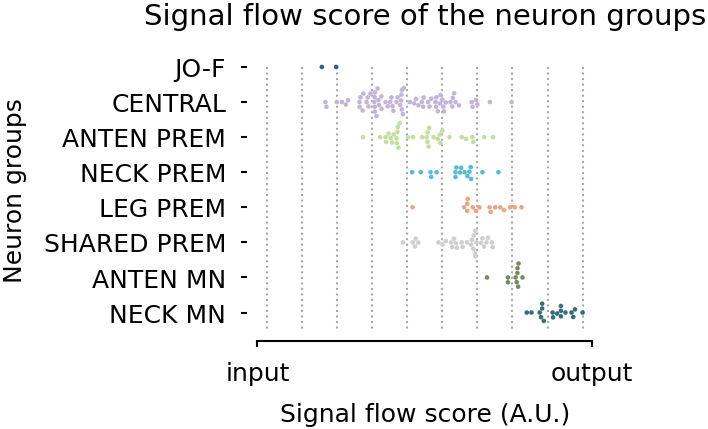

In [20]:
neuron_groups = {
    "JO-F": list(sensory_motor["jo_f"]),
    "CENTRAL": list(sensory_motor["central"]),
    "ANTEN_PREM": list(sensory_motor["anten_prem"]),
    "NECK_PREM": list(sensory_motor["neck_prem"]),
    "LEG_PREM": list(sensory_motor["leg_prem"]),
    "SHARED_PREM": list(sensory_motor["shared_prem"]),
    "ANTEN_MN": list(sensory_motor["anten_mn"]),
    "NECK_MN": list(sensory_motor["neck_mn"]),
}

with plt.style.context("./config.mplstyle"):

    fig, ax = plt.subplots(
        figsize=(FIGSIZE["width"] * 1.2, FIGSIZE["length"] * 1.35), dpi=300
    )
    ax.vlines(
        layer_bounds, ymin=0, ymax=no_layers, ls=":", label="layers", color="darkgrey"
    )

    # swarmplot
    sns.swarmplot(
        data=[
            z_sorted[np.isin(nodes, neuron_ids)]
            for neuron_group, neuron_ids in neuron_groups.items()
        ],
        ax=ax,
        palette=[
            "#335F7C",
            "#C3B5D9",
            "#C2DFA0",
            "#59BAD6",
            "#E9A686",
            "#CFCFCE",
            "#798963",
            "#356D7A",
        ],
        orient="h",
        size=1.1,
    )
    ax.set_yticks(
        ticks=np.arange(0, len(neuron_groups)),
        labels=[name.replace("_", " ") for name in neuron_groups.keys()],
    )
    ax.set_xticks(
        ticks=[np.min(z_sorted) - 0.1, np.max(z_sorted) + 0.1],
        labels=["output", "input"],
    )
    ax.set_xlim((np.min(z_sorted) - 0.1, np.max(z_sorted) + 0.1))
    ax.invert_xaxis()
    ax.set_title("Signal flow score of the neuron groups")
    ax.set_ylabel("Neuron groups")
    ax.set_xlabel("Signal flow score (A.U.)")
    set_outward_spines(ax)
    ax.spines.left.set_visible(False)
    fig.savefig(
        EXPORT_PATH / "Fig4_panelH_signal_flow.png", bbox_inches="tight", dpi=300
    )
    plt.show()

## Panel I: connectivity between layers

In [21]:
layer_by_layer, layer_by_layer_inh, layer_by_layer_exc = (
    graph_tools.get_connectivity_between_layers(layer_neurons, grooming_network)
)

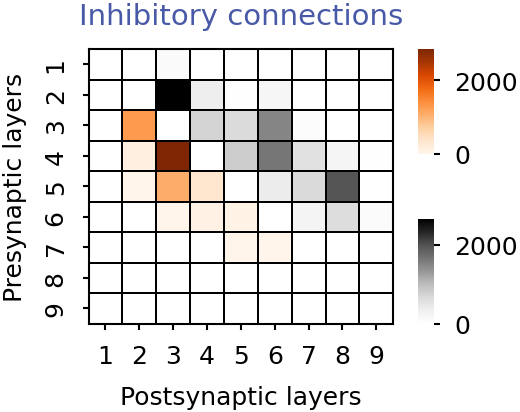

In [22]:
with plt.style.context("./config.mplstyle"):
    plt.style.use("./config.mplstyle")
    np.fill_diagonal(layer_by_layer_inh, 0)

    # Create the figure with constrained layout to avoid overlap
    fig = plt.figure(
        figsize=(FIGSIZE["width"] * 1.5, FIGSIZE["length"] * 1.6),
        dpi=300,
        constrained_layout=True,
    )

    # Define grid spec for the figure
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 0.05])

    # Setup for first plot
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    sns.heatmap(
        layer_by_layer_inh,
        annot=False,
        cmap="Oranges",
        cbar=True,
        ax=ax1,
        cbar_ax=ax2,
        linecolor="black",
        linewidth=0.1,
        xticklabels=list(layer_neurons.keys()),
        yticklabels=list(layer_neurons.keys()),
        fmt=".3g",
        mask=np.triu(layer_by_layer_inh),
        cbar_kws={
            # 'label': 'Forward conn.', 'ticks': [],
            "shrink": 0.7
        },
    )
    sns.heatmap(
        layer_by_layer_inh,
        annot=False,
        cmap="Greys",
        cbar=True,
        cbar_ax=ax3,
        ax=ax1,
        linecolor="black",
        linewidth=0.1,
        xticklabels=list(layer_neurons.keys()),
        yticklabels=list(layer_neurons.keys()),
        fmt=".3g",
        mask=np.tril(layer_by_layer_inh),
        cbar_kws={
            # 'label': 'Forward conn.', 'ticks': [],
            "shrink": 0.7
        },
    )
    # cbar.ax.tick_params(labelsize=5)
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)
    ax1.set_ylabel("Presynaptic layers")
    ax1.set_xlabel("Postsynaptic layers")
    ax1.set_title(f"Inhibitory connections", color="#4859A7")
    ax1.spines.bottom.set_visible(True)
    ax1.spines.right.set_visible(True)
    ax1.spines.left.set_visible(True)
    ax1.spines.top.set_visible(True)

    fig.savefig(EXPORT_PATH / f"Fig4_panelI_heatmap_layer_conn_inh.png")

    plt.show()

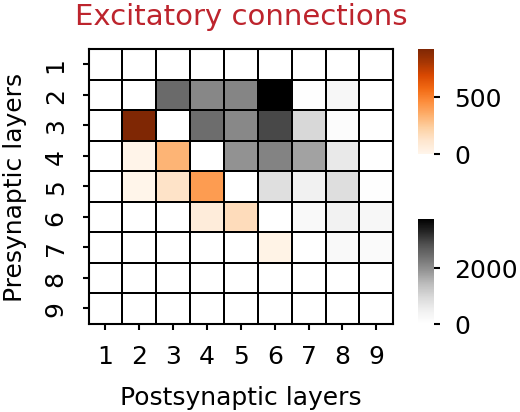

In [23]:
with plt.style.context("./config.mplstyle"):
    plt.style.use("./config.mplstyle")
    np.fill_diagonal(layer_by_layer_exc, 0)

    # Create the figure with constrained layout to avoid overlap
    fig = plt.figure(
        figsize=(FIGSIZE["width"] * 1.5, FIGSIZE["length"] * 1.6),
        dpi=300,
        constrained_layout=True,
    )
    # Define grid spec for the figure
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 0.05])

    # Setup for first plot
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    sns.heatmap(
        layer_by_layer_exc,
        annot=False,
        cmap="Oranges",
        cbar=True,
        ax=ax1,
        cbar_ax=ax2,
        linecolor="black",
        linewidth=0.1,
        xticklabels=list(layer_neurons.keys()),
        yticklabels=list(layer_neurons.keys()),
        fmt=".3g",
        mask=np.triu(layer_by_layer_exc),
        cbar_kws={
            # 'label': 'Forward conn.', 'ticks': [],
            "shrink": 0.7
        },
    )
    sns.heatmap(
        layer_by_layer_exc,
        annot=False,
        cmap="Greys",
        cbar=True,
        ax=ax1,
        cbar_ax=ax3,
        linecolor="black",
        linewidth=0.1,
        xticklabels=list(layer_neurons.keys()),
        yticklabels=list(layer_neurons.keys()),
        fmt=".3g",
        mask=np.tril(layer_by_layer_exc),
        cbar_kws={
            # 'label': 'Forward conn.', 'ticks': [],
            "shrink": 0.7
        },
    )
    # cbar.ax.tick_params(labelsize=5)
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)
    ax1.set_ylabel("Presynaptic layers")
    ax1.set_xlabel("Postsynaptic layers")
    ax1.set_title(f"Excitatory connections", color="#BD242D")
    ax1.spines.bottom.set_visible(True)
    ax1.spines.right.set_visible(True)
    ax1.spines.left.set_visible(True)
    ax1.spines.top.set_visible(True)

    fig.savefig(EXPORT_PATH / f"Fig4_panelI_heatmap_layer_conn_exc.pdf")

    plt.show()

## Panel J: graph representation of the connections 

Note that we modified the graph in Gephi to obtain the publication version.

In [24]:
input_central_to_prem_array = graph_tools.get_conn_between_groups(
    grooming_network, sensory_motor
)

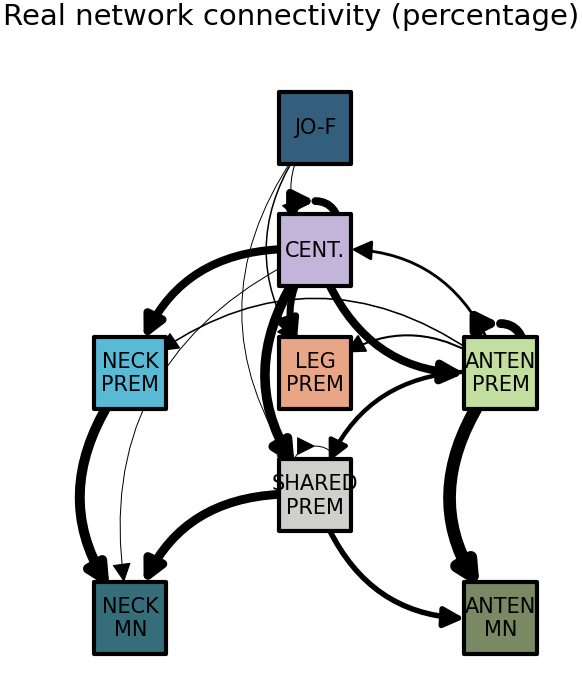

In [25]:
pos_custom = {
    "JO-F": (0.0, 3),
    "CENT.": (-0.0, 2.),
    "ANTEN PREM": (1.2, 1),
    "LEG PREM": (0.0, 1),
    "NECK PREM": (-1.2, 1),
    "SHARED PREM": (0, 0),
    "ANTEN MN": (1.2, -1.),
    "NECK MN": (-1.2, -1.),
}

NODE_COLORS = {
    "JO-F": "#335F7C",
    "CENT.": "#C3B5D9",
    "ANTEN PREM": "#C2DFA0",
    "NECK PREM": "#59BAD6",
    "LEG PREM": "#E9A686",
    "SHARED PREM": "#CFCFCE",
    "ANTEN MN": "#798963",
    "NECK MN": "#356D7A",
}

with plt.style.context("./config.mplstyle"):
    graph, edges = graph_tools.draw_graph(
        input_central_to_prem_array[:-1, :] / 20,
        neuron_group_names_pre=[
            "JO-F",
            "CENT.",
            "ANTEN PREM",
            "NECK PREM",
            "LEG PREM",
            "SHARED PREM",
        ],
        neuron_group_names_post=[
            "CENT.",
            "ANTEN PREM",
            "NECK PREM",
            "LEG PREM",
            "SHARED PREM",
            "ANTEN MN",
            "NECK MN",
        ],
        pos_custom=pos_custom,
        node_colors=NODE_COLORS,
        title="Real network connectivity (percentage)",
        fig_name="Fig4_panelJ",
        normalize_edge_weight=False,
        threshold=0.2,
        edge_label=False,
        connectionstyle="arc3,rad=0.4",
        export_path=EXPORT_PATH,
    )

    plt.show()

## Panel K: connectivity strength between different neuron groups

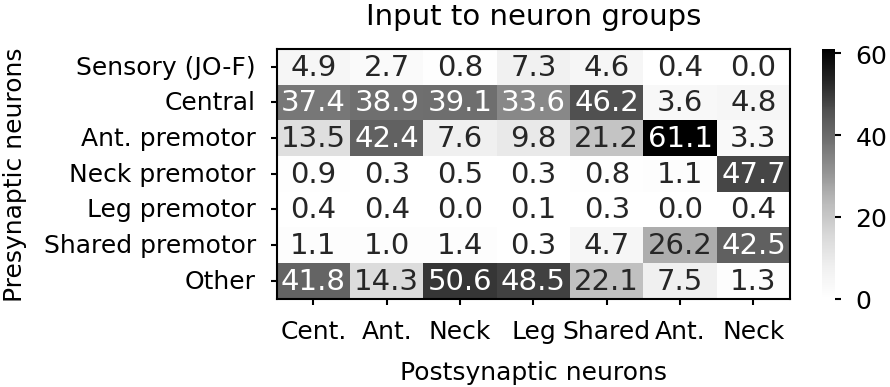

In [26]:
with plt.style.context("./config.mplstyle"):
    fig, ax = plt.subplots(
        1, 1, figsize=(FIGSIZE["width"] * 2.3, FIGSIZE["length"] * 1.2)
    )
    sns.heatmap(
        input_central_to_prem_array,
        cmap="Greys",
        annot=True,
        fmt=".1f",
        xticklabels=["Cent.", "Ant.", "Neck", "Leg", "Shared", "Ant.", "Neck"],
        yticklabels=["Sensory (JO-F)", "Central", "Ant. premotor", "Neck premotor", "Leg premotor", "Shared premotor", "Other"],
        ax=ax,
        # vmin=layer_by_layer_inh.min(),
        # vmax=layer_by_layer_inh.max(),
        cbar=True,
        linecolor="black",
        # linewidth=0.1,
        # cbar_kws={"label": "Percentage (%)", "shrink": 0.8},
    )
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)

    ax.set_title("Input to neuron groups")
    ax.set_ylabel("Presynaptic neurons")
    ax.set_xlabel("Postsynaptic neurons")
    plt.xticks(rotation=0)
    fig.savefig(EXPORT_PATH / "Fig4_panelK_central_input_to_motor_modules.png", bbox_inches='tight', dpi=300)
    plt.show()

## Panel L

In [28]:
NODE_COLORS

{'JO-F': '#335F7C',
 'CENT.': '#C3B5D9',
 'ANTEN PREM': '#C2DFA0',
 'NECK PREM': '#59BAD6',
 'LEG PREM': '#E9A686',
 'SHARED PREM': '#CFCFCE',
 'ANTEN MN': '#798963',
 'NECK MN': '#356D7A'}

KeyError: 'NECK_PREM'

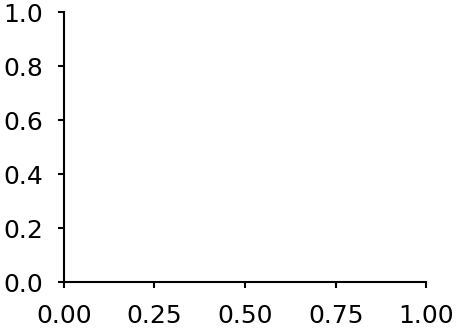

In [ ]:
NODE_COLORS = {
    "JO-F": "#D45B83",
    'JO-C': "#934161",
    'JO-E': "#4F2334",
    "CENTRAL": "#C3B5D9",
    "ANTEN_PREM": "#C2DFA0",
    "NECK_PREM": "#59BAD6",
    "LEG_PREM": "#E9A686",
    "SHARED_PREM": "#CFCFCE",
    "ANTEN_MN": "#798963",
    "NECK_MN": "#356D7A",
    "OTHER": "black"
}

# Venn diagram of neck and antennal premotor neurons
with plt.style.context("./config.mplstyle"):
    fig, ax = plt.subplots(
        1, 1, figsize=(FIGSIZE["width"] * 1.3, FIGSIZE["length"] * 1.3)
    )
    matplotlib_venn.venn3(
        [neck_prem_neurons, anten_prem_neurons, leg_prem_neurons],
        set_labels=("Neck\npremotor", "Antennal\npremotor", "Foreleg\npremotor (DNs)"),
        set_colors=(
            NODE_COLORS["NECK_PREM"],
            NODE_COLORS["ANTEN_PREM"],
            NODE_COLORS["LEG_PREM"],
        ),
        alpha=0.6,
    )

    fig.savefig(
        EXPORT_PATH / "Fig4_panelL_venn_prems.png", bbox_inches="tight", dpi=300
    )

## Panel M

Neck motor neurons receive 42.53% of their input from shared premotor neurons
Antennal motor neurons receive 26.22% of their input from shared premotor neurons


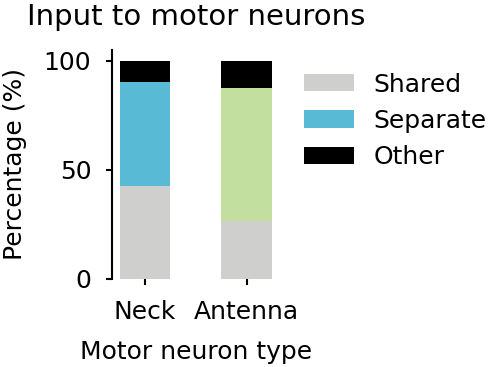

In [ ]:
neck_input_percen, anten_input_percen = graph_tools.get_panel_m(
    grooming_network,
    sensory_motor,
    shared_prem=set(sensory_motor["shared_prem"]),
    anten_prem_set=set(sensory_motor["anten_prem"]),
    neck_prem_set=set(sensory_motor["neck_prem"]),
)

# plot percentages as stacked bar plot
plt.style.use("./config.mplstyle")

with plt.style.context("./config.mplstyle"):
    fig, ax = plt.subplots(
        1, 1, figsize=(FIGSIZE["width"] * 0.6, FIGSIZE["length"] * 1.1)
    )
    # Shared
    ax.bar(
        0,
        neck_input_percen["shared"],
        color="#CFCFCE",
        label="Shared",
        linewidth=0.1,
        width=0.5,
    )
    # Individual
    ax.bar(
        0,
        neck_input_percen["ind"],
        bottom=neck_input_percen["shared"],
        color=NODE_COLORS["NECK_PREM"],
        # hatch="///",
        linewidth=0.1,
        label="Separate",
        width=0.5,
    )
    # Other
    ax.bar(
        0,
        100 - sum(neck_input_percen.values()),
        bottom=neck_input_percen["shared"] + neck_input_percen["ind"],
        color="black",
        label="Other",
        linewidth=0.1,
        width=0.5,
    )
    # Anten - shared
    ax.bar(
        1,
        anten_input_percen["shared"],
        color="#CFCFCE",
        linewidth=0.1,
        width=0.5,
    )
    # Individual
    ax.bar(
        1,
        anten_input_percen["ind"],
        bottom=anten_input_percen["shared"],
        color=NODE_COLORS["ANTEN_PREM"],
        linewidth=0.1,
        width=0.5,
    )
    # Other
    ax.bar(
        1,
        100 - sum(anten_input_percen.values()),
        bottom=anten_input_percen["shared"] + anten_input_percen["ind"],
        color="black",
        linewidth=0.1,
        width=0.5,
    )

    # xlabels
    ax.set_xticks([0, 1], labels=["Neck", "Antenna"])
    # bottom spine invisible
    ax.spines["bottom"].set_visible(False)

    # legend
    ax.legend(bbox_to_anchor=(1.01, 1))
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Motor neuron type")
    ax.set_title("Input to motor neurons")
    fig.savefig(
        EXPORT_PATH / "Fig4_panelM_shared_premotor_input.png",
        bbox_inches="tight",
        dpi=300,
    )

### Panel N is provided in EDFigure9.ipynb